# Hypothesis 2: Leadership Impact Analysis

**Goal:** Validate if "High Quality" leaders (consistent, experienced) generate higher user retention.

**Scope:** Post-2023 Data only (to avoid COVID/Virtual bias).

---

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Add src to path to import data_loader
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_loader import FitFamDataLoader

# Initialize Loader
loader = FitFamDataLoader(data_dir=os.path.abspath(os.path.join('..', 'fitfam-json')))

print("Loading Data...")
events = loader.load_events()
event_user = loader.load_event_user()
print("Data Loaded.")

Loading Data...
Data Loaded.


## 2. Data Filtering (Post-2023)

In [2]:
print("--- Filtering Data (Post-2023) ---")
events['start_time'] = pd.to_datetime(events['start_time'])
events_filtered = events[events['start_time'] >= '2023-01-01'].copy()
print(f"Events (Total): {len(events)}")
print(f"Events (Post-2023): {len(events_filtered)}")

# Filter attendance to only include these events
event_user_filtered = event_user[event_user['event_id'].isin(events_filtered['id'])].copy()
print(f"Attendance (Total): {len(event_user)}")
print(f"Attendance (Post-2023): {len(event_user_filtered)}")

--- Filtering Data (Post-2023) ---
Events (Total): 37630
Events (Post-2023): 12141
Attendance (Total): 405861
Attendance (Post-2023): 94838


## 3. Step 1: Data Discovery (Leader Verification)

In [ ]:
if 'is_leader' in event_user_filtered.columns:
    leaders_from_attendance = event_user_filtered[event_user_filtered['is_leader'] == 1]
    print(f"{len(leaders_from_attendance)} leader records.")
    
    if not leaders_from_attendance.empty:
        leader_counts = leaders_from_attendance.groupby('user_id').size().reset_index(name='event_count')
        print(f"Total unique leaders: {len(leader_counts)}")
        
        active_leaders = leader_counts[leader_counts['event_count'] >= 5]
        print(f"Active Leaders (>= 5 events): {len(active_leaders)}")
        print(leader_counts['event_count'].describe())
else:
    print("ERROR")

Found 10070 leader records.
Total unique leaders: 187
Active Leaders (>= 5 events): 160
count    187.000000
mean      53.850267
std       64.332462
min        1.000000
25%       10.000000
50%       30.000000
75%       74.500000
max      437.000000
Name: event_count, dtype: float64


## 4. Step 2: Feature Engineering (Leader Quality Metrics)

**Metrics:**
*   **Consistency:** Std Dev of days between events.
*   **Tenure:** Days between first and last event.
*   **Frequency:** Events per month.

In [4]:
# Merge Leaders with Event Dates
leaders = event_user_filtered[event_user_filtered['is_leader'] == 1].copy()
leaders_with_dates = leaders.merge(events_filtered[['id', 'start_time']], left_on='event_id', right_on='id', how='left')
leaders_with_dates = leaders_with_dates.sort_values(['user_id', 'start_time'])

leader_stats = []

print("Calculating metrics...")

for user_id, group in leaders_with_dates.groupby('user_id'):
    dates = group['start_time'].sort_values()
    
    total_events = len(group)
    first_led = dates.iloc[0]
    last_led = dates.iloc[-1]
    
    tenure_days = (last_led - first_led).days
    if tenure_days == 0: tenure_days = 1 
    
    events_per_month = total_events / (tenure_days / 30.44)
    
    if total_events > 1:
        gaps = dates.diff().dt.total_seconds() / (24 * 3600)
        gaps = gaps.dropna()
        consistency_std = gaps.std()
        avg_gap = gaps.mean()
    else:
        consistency_std = np.nan 
        avg_gap = np.nan
        
    leader_stats.append({
        'leader_user_id': user_id,
        'total_events': total_events,
        'first_led_date': first_led,
        'last_led_date': last_led,
        'tenure_days': tenure_days,
        'events_per_month': events_per_month,
        'consistency_std': consistency_std,
        'avg_gap_days': avg_gap
    })

df_leaders = pd.DataFrame(leader_stats)

if not df_leaders.empty:
    df_leaders.set_index('leader_user_id', inplace=True)
    print(f"Computed stats for {len(df_leaders)} leaders.")
    
    # Save
    df_leaders.to_csv('leaders_quality_metrics_filtered.csv')
    print("Saved to leaders_quality_metrics_filtered.csv")
    
    # Inspect
    print("\nTop 5 Consistent Leaders (Min 10 events):")
    print(df_leaders[df_leaders['total_events'] >= 10].sort_values('consistency_std').head(5)[['total_events', 'consistency_std', 'events_per_month']])
else:
    print("No leaders found in filtered data.")

Calculating metrics...
Computed stats for 187 leaders.
Saved to leaders_quality_metrics_filtered.csv

Top 5 Consistent Leaders (Min 10 events):
                total_events  consistency_std  events_per_month
leader_user_id                                                 
102842                    19         0.004910          4.626880
226                       57         1.590454          4.201162
7844                      17         1.750000          4.348571
66                       224         2.509773          8.555282
32608                     12         2.662876          6.522857


## 5. User Cohorts & Retention

* Assign every user to a "First Leader" and calculate if they were retained.

1.  Identify the **First Event** for every user.
2.  Identify the **Leader** of that first event.
3.  Calculate **Retention**: Did they attend any event > 90 days after their first event?

In [5]:
print("--- Step 3: User Cohorts ---")

# 1. Get First Event for each User
# Merge attendance with event dates
attendance_with_dates = event_user_filtered.merge(events_filtered[['id', 'start_time']], left_on='event_id', right_on='id', how='inner')

# Sort by user and time
attendance_with_dates = attendance_with_dates.sort_values(['user_id', 'start_time'])

# Group by user to find first and last event
user_stats = attendance_with_dates.groupby('user_id').agg(
    first_event_id=('event_id', 'first'),
    first_event_date=('start_time', 'first'),
    last_event_date=('start_time', 'last'),
    total_attendance=('event_id', 'count')
).reset_index()

print(f"Total Users (Post-2023): {len(user_stats)}")

# 2. Calculate Retention (90 Days)
user_stats['retention_days'] = (user_stats['last_event_date'] - user_stats['first_event_date']).dt.days
user_stats['is_retained_90d'] = user_stats['retention_days'] >= 90

print(f"Retained Users (>90 days): {user_stats['is_retained_90d'].sum()} ({user_stats['is_retained_90d'].mean():.1%})")

# 3. Link to First Leader
# We need to know who led 'first_event_id'
# Create a mapping: event_id -> leader_user_id
event_leader_map = event_user_filtered[event_user_filtered['is_leader'] == 1][['event_id', 'user_id']].drop_duplicates('event_id')
event_leader_map.columns = ['event_id', 'leader_user_id']

# Merge user_stats with leader map
user_cohorts = user_stats.merge(event_leader_map, left_on='first_event_id', right_on='event_id', how='left')

# Filter out users whose first event had no recorded leader (or guest leader)
user_cohorts_clean = user_cohorts.dropna(subset=['leader_user_id'])
print(f"Users with identified First Leader: {len(user_cohorts_clean)}")

# 4. Save
user_cohorts_clean.to_csv('user_cohorts.csv', index=False)
print("Saved to user_cohorts.csv")

user_cohorts_clean.head()

--- Step 3: User Cohorts ---
Total Users (Post-2023): 6111
Retained Users (>90 days): 2160 (35.3%)
Users with identified First Leader: 5536
Saved to user_cohorts.csv


,user_id,first_event_id,first_event_date,last_event_date,total_attendance,retention_days,is_retained_90d,event_id,leader_user_id
0,2,29567,2023-08-22 06:00:00,2024-04-18 05:30:00,11,239,True,29567.0,35.0
1,3,27002,2023-04-09 01:01:00,2025-03-08 10:00:00,91,699,True,27002.0,35.0
2,6,25591,2023-01-04 07:00:00,2025-03-10 19:00:00,187,796,True,25591.0,6.0
3,9,26219,2023-02-10 06:00:00,2024-10-30 06:00:00,130,628,True,26219.0,50820.0
4,10,26160,2023-02-07 19:30:00,2024-10-10 19:30:00,17,611,True,26160.0,39741.0


## 6. Step 4: Statistical Analysis

**Goal:** Test if Leader Quality correlates with User Retention.

**Method:**
1.  Merge `user_cohorts` with `df_leaders` (Quality Metrics).
2.  **Correlation:** Check correlation between `consistency_std` and `is_retained_90d`.
3.  **Segmentation:** Compare retention rates for Top 25% vs Bottom 25% consistent leaders.

In [8]:
print("--- Step 4: Analysis ---")

# 1. Merge User Cohorts with Leader Metrics
# We use 'leader_user_id' from user_cohorts and index from df_leaders
analysis_df = user_cohorts_clean.merge(df_leaders, left_on='leader_user_id', right_index=True, how='inner')

print(f"Users included in analysis: {len(analysis_df)}")

# 2. Correlation Analysis
# We want to see if Leader Consistency (lower std dev) -> Higher Retention
corr = analysis_df[['is_retained_90d', 'consistency_std', 'tenure_days', 'events_per_month']].corr()
print("\nCorrelation Matrix (Target: is_retained_90d):")
print(corr['is_retained_90d'])

# 3. Segmentation (Top vs Bottom Consistency)
# Filter for leaders with enough history (>10 events) to have a valid consistency score
valid_leaders_df = analysis_df[analysis_df['total_events'] >= 10].copy()

# Define Quartiles for Consistency (Lower is Better)
q1 = valid_leaders_df['consistency_std'].quantile(0.25)
q3 = valid_leaders_df['consistency_std'].quantile(0.75)

top_tier_leaders = valid_leaders_df[valid_leaders_df['consistency_std'] <= q1]
bottom_tier_leaders = valid_leaders_df[valid_leaders_df['consistency_std'] >= q3]

print(f"\nTop Tier Leaders (Consistent): {len(top_tier_leaders)} users")
print(f"Bottom Tier Leaders (Inconsistent): {len(bottom_tier_leaders)} users")

retention_top = top_tier_leaders['is_retained_90d'].mean()
retention_bottom = bottom_tier_leaders['is_retained_90d'].mean()

print(f"\nRetention Rate (Top Tier): {retention_top:.1%}")
print(f"Retention Rate (Bottom Tier): {retention_bottom:.1%}")
print(f"Lift: {(retention_top - retention_bottom) / retention_bottom:.1%}")

--- Step 4: Analysis ---
Users included in analysis: 5536

Correlation Matrix (Target: is_retained_90d):
is_retained_90d     1.000000
consistency_std     0.009184
tenure_days        -0.038218
events_per_month    0.008920
Name: is_retained_90d, dtype: float64

Top Tier Leaders (Consistent): 1364 users
Bottom Tier Leaders (Inconsistent): 1440 users

Retention Rate (Top Tier): 37.2%
Retention Rate (Bottom Tier): 32.4%
Lift: 14.9%


## 7. Step 5: Visualization

**Goal:** Visualize the impact of Leader Consistency on User Retention.

**Charts:**
1.  **Bar Chart:** Retention Rate by Leader Tier.
2.  **Survival Curve:** Retention over time for Top vs Bottom Tier.

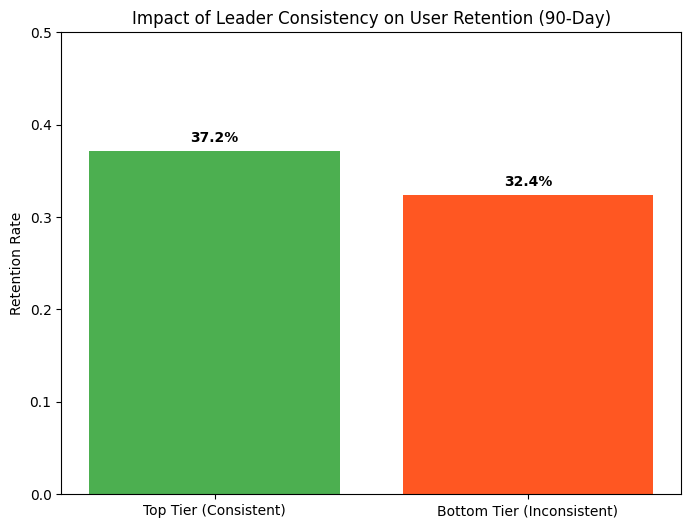

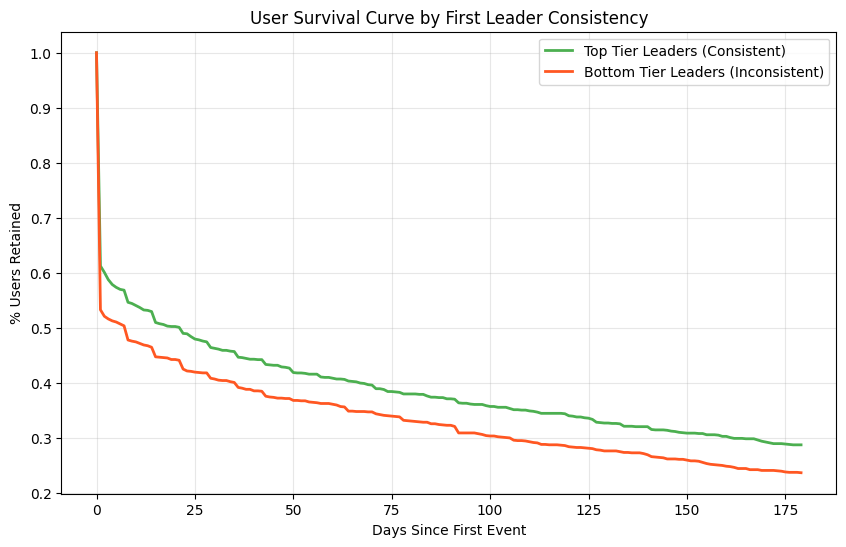

In [9]:
import matplotlib.pyplot as plt

# 1. Bar Chart: Retention by Tier
tiers = ['Top Tier (Consistent)', 'Bottom Tier (Inconsistent)']
rates = [retention_top, retention_bottom]

plt.figure(figsize=(8, 6))
plt.bar(tiers, rates, color=['#4CAF50', '#FF5722'])
plt.title('Impact of Leader Consistency on User Retention (90-Day)')
plt.ylabel('Retention Rate')
plt.ylim(0, 0.5)
for i, v in enumerate(rates):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', fontweight='bold')
plt.savefig('retention_by_leader_tier.png')
plt.show()

# 2. Survival Curve (Manual Implementation)
# We calculate the % of users retained at each day (0 to 180)

def calculate_survival(df, max_days=180):
    survival_rates = []
    total_users = len(df)
    for day in range(max_days):
        # Users who stayed AT LEAST 'day' days
        retained_count = df[df['retention_days'] >= day].shape[0]
        survival_rates.append(retained_count / total_users)
    return survival_rates

days = range(180)
survival_top = calculate_survival(top_tier_leaders)
survival_bottom = calculate_survival(bottom_tier_leaders)

plt.figure(figsize=(10, 6))
plt.plot(days, survival_top, label='Top Tier Leaders (Consistent)', color='#4CAF50', linewidth=2)
plt.plot(days, survival_bottom, label='Bottom Tier Leaders (Inconsistent)', color='#FF5722', linewidth=2)

plt.title('User Survival Curve by First Leader Consistency')
plt.xlabel('Days Since First Event')
plt.ylabel('% Users Retained')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('survival_curve_by_leader.png')
plt.show()